# Midterm Report

## Import chatGPT detector model

In [6]:
import torch
import io 
import jsonlines
import pandas as pd
import numpy as np 
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [7]:
model = torch.load('detector-base.pt') 

## Import cleaned HC3 dataset

In [42]:
df = pd.read_parquet('clean_df.parq')
df = df.sample(frac=1, axis=1, random_state=0).sample(frac=1, random_state=0).reset_index(drop=True)

# Establish detector pipeline 

In [9]:
test_case = df['answer'][0]
test_case

'Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you \'re still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n\'t stay there for long , you still achieved the status . Hence , # 1 best seller .'

## Run on a single test case

In [10]:
import numpy as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
if device.type == "cpu":
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base-openai-detector"
    )
else:
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base-openai-detector", device_map="auto"
    )

input_text = test_case

input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    logits = model(input_ids).logits

predicted_class_id = logits.argmax().item()
predicted_probs = torch.nn.functional.softmax(logits, dim=1).data.tolist()[0]
print(
    model.config.id2label[predicted_class_id],
    predicted_probs[nn.argmax(predicted_probs)],
)

Using device: cpu


Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Real 0.9998311996459961


# Extract misclassified data

In [46]:
subset_df = df.loc[0:999,:].copy()
subset_df.shape

(1000, 5)

In [47]:
def get_prediction(df):
    class_labels = []
    class_probs = []
    oversized_inputs = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
    if device.type == "cpu":
        model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base-openai-detector"
        )
    else:
        model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base-openai-detector", device_map="auto"
        )

    counter = 0 
    for response in df['answer']:
        if counter%50 == 0:
            print(f'Predicting question {counter} out of {len(df)} ({round(counter*100/len(df), 2)}% complete)')
        counter += 1
        input_text = response
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

        if input_ids.shape[1] > 512: # Error handling for max input size 
            input_ids.resize_(input_ids.shape[0], 512)
            oversized_inputs.append(response)

        with torch.no_grad():
            logits = model(input_ids).logits

        predicted_class_id = logits.argmax().item()
        predicted_probs = torch.nn.functional.softmax(logits, dim=1).data.tolist()[0]
        
        # questions.append(row['question'])
        # responses.append(real_response)
        # actual_labels.append('Real')
        class_labels.append(model.config.id2label[predicted_class_id])
        class_probs.append(predicted_probs[nn.argmax(predicted_probs)])
        
        
    # # for gpt_response in row['chatgpt_answers']:
    # #     input_text = gpt_response
    # #     input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
        
    # #     if input_ids.shape[1] > 512: # Error handling for max input size 
    # #         input_ids.resize_(input_ids.shape[0], 512)
    # #         oversized_inputs.append(gpt_response)

    # #     with torch.no_grad():
    # #         logits = model(input_ids).logits

    # #     predicted_class_id = logits.argmax().item()
    # #     predicted_probs = torch.nn.functional.softmax(logits, dim=1).data.tolist()[0]
        
    # #     questions.append(row['question'])
    # #     responses.append(real_response)
    # #     actual_labels.append('Fake')
    #     class_labels.append(model.config.id2label[predicted_class_id])
    #     class_probs.append(predicted_probs[nn.argmax(predicted_probs)])

    return class_labels, class_probs, oversized_inputs

class_labels, class_probs, oversized_inputs = get_prediction(subset_df)

Using device: cpu


Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicting question 0 out of 1000 (0.0% complete)


Token indices sequence length is longer than the specified maximum sequence length for this model (826 > 512). Running this sequence through the model will result in indexing errors


Predicting question 50 out of 1000 (5.0% complete)
Predicting question 100 out of 1000 (10.0% complete)
Predicting question 150 out of 1000 (15.0% complete)
Predicting question 200 out of 1000 (20.0% complete)
Predicting question 250 out of 1000 (25.0% complete)
Predicting question 300 out of 1000 (30.0% complete)
Predicting question 350 out of 1000 (35.0% complete)
Predicting question 400 out of 1000 (40.0% complete)
Predicting question 450 out of 1000 (45.0% complete)
Predicting question 500 out of 1000 (50.0% complete)
Predicting question 550 out of 1000 (55.0% complete)
Predicting question 600 out of 1000 (60.0% complete)
Predicting question 650 out of 1000 (65.0% complete)
Predicting question 700 out of 1000 (70.0% complete)
Predicting question 750 out of 1000 (75.0% complete)
Predicting question 800 out of 1000 (80.0% complete)
Predicting question 850 out of 1000 (85.0% complete)
Predicting question 900 out of 1000 (90.0% complete)
Predicting question 950 out of 1000 (95.0% compl

In [49]:
len(class_labels), len(class_probs), len(oversized_inputs)

(1000, 1000, 41)

In [50]:
subset_df["pred_label"] = class_labels
subset_df["pred_probability"] = class_probs

In [57]:
misclassified_texts = subset_df[subset_df['true_label'] != subset_df['pred_label']]
misclassified_texts = misclassified_texts.sort_values(by='pred_probability', ascending=True)
print(misclassified_texts.shape)
# misclassified texts data quality checks - should not have any real-real / fake-fake
misclassified_texts.groupby(['true_label', 'pred_label']).count()

(44, 7)


,,answer,q_id,question,source,pred_probability
true_label,pred_label,,,,,
Fake,Real,17,17,17,17,17
Real,Fake,27,27,27,27,27


In [58]:
misclassified_texts.to_csv('misclassified_sample.csv')

# Explore misclassified

In [54]:
confusion_matrix = pd.crosstab(subset_df['true_label'], subset_df['pred_label'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,Fake,Real
Actual,,
Fake,314,17
Real,27,642


In [60]:
accuracy_score(subset_df['true_label'], subset_df['pred_label'])

0.956

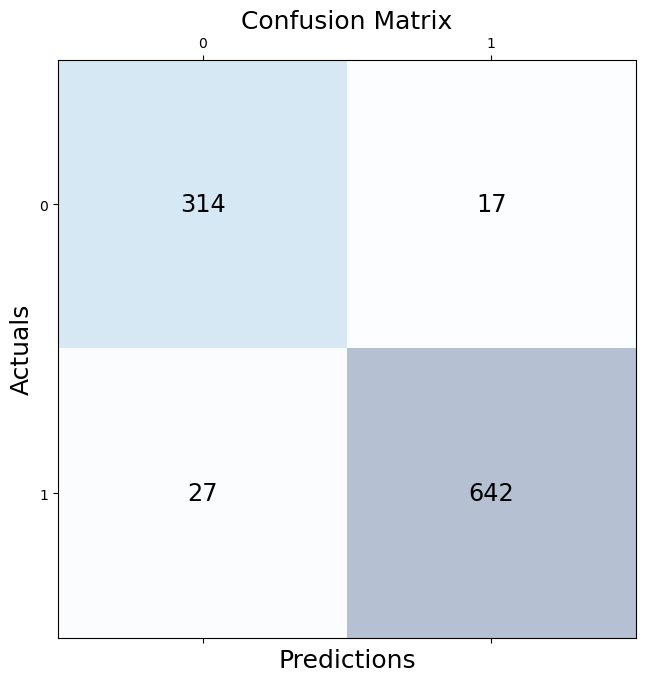

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(subset_df['true_label'], subset_df['pred_label'])

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

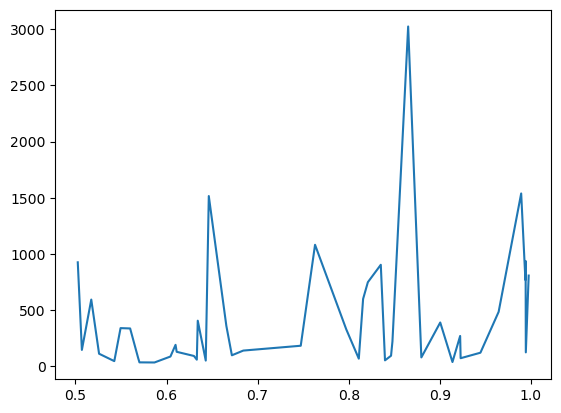

In [65]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)

misclassified_texts['char_length'] = [len(i) for i in misclassified_texts['answer']]
misclassified_texts['cum_char_length'] = misclassified_texts['char_length'].cumsum()

#misclassified_texts = misclassified_texts.sort_values(by='pred_probability')

plt.plot(misclassified_texts['pred_probability'][0:100], misclassified_texts['char_length'][0:100])
plt.show()

In [ ]:
np.corrcoef(misclassified_texts['char_length'], misclassified_texts['pred_probability'])
from scipy.stats import pearsonr

pearsonr(misclassified_texts['char_length'], misclassified_texts['pred_probability'])

PearsonRResult(statistic=0.07143339516844117, pvalue=0.3802380166296405)

In [ ]:
fake_misclassified_texts = misclassified_texts[misclassified_texts['actual_label']=='Fake']
real_misclassified_texts = misclassified_texts[misclassified_texts['actual_label']=='Real']